In [1]:
import torch

print(torch.cuda.is_available())


True


In [2]:
from torchmetrics import ROC
import matplotlib.pyplot as plt
from itertools import cycle
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [3]:
#Part 3 and 4
#Changing the directories

%cd C:\Users\aksho\OneDrive\Desktop\ML_Assessment_2

C:\Users\aksho\OneDrive\Desktop\ML_Assessment_2


In [4]:
#1 Load, preprocess, analyze, visualize the dataset and make it ready for training

#This piece of code calculates all the file paths for the images in the dataset, and the mean and deviation for the pixel values
#Those values will be later used to normalize the image tensors
import torch
import glob
import os
from PIL import Image
from torchvision import transforms

# Ensure CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

source = 'C:/Users/aksho/OneDrive/Desktop/ML_Assessment_2/cnn_dataset/'

all_image_paths = []
all_image_labels = []

# This is list of all the directories
directory_list = [directory for root, directory, path in os.walk(source)]
required_directory = directory_list[0]
for folder in required_directory:
    full_directory = os.path.join(source, folder)
    image_directory = os.path.join(full_directory, '*.png')
    image_paths = glob.glob(image_directory)
    all_image_paths.extend(image_paths)
    all_image_labels.extend([folder] * len(image_paths))

convert_to_tensor = transforms.ToTensor()
total_pixels = 0
total_mean = torch.zeros(3, device=device)
total_std = torch.zeros(3, device=device)

for image_path in all_image_paths:
    image = Image.open(image_path).convert('RGB')
    image_tensor = convert_to_tensor(image).to(device)
    
    pixel_per_image = image_tensor.shape[1] * image_tensor.shape[2]
    
    total_pixels += pixel_per_image
    
    # Calculating the mean
    total_mean += image_tensor.mean([1, 2]) * pixel_per_image
    
    # Calculating the deviation
    total_std += ((image_tensor - image_tensor.mean([1, 2], keepdim=True)) ** 2).sum([1, 2])

# Final mean and standard deviation calculations
mean = total_mean / total_pixels
std = (total_std / total_pixels).sqrt()

# Moveing the mean backto CPU
mean = mean.cpu()
std = std.cpu()

print(mean, std)

tensor([0.1758, 0.1758, 0.1758]) tensor([0.3296, 0.3296, 0.3296])


In [ ]:
#Data Visualization



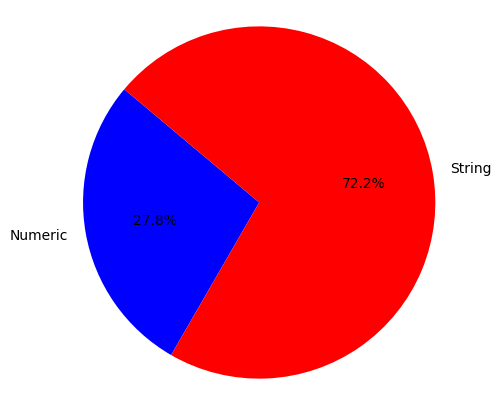

In [29]:
#Visualization graphs

#Chart 1

numeric_count = 0
string_count = 0
    
for item in required_directory:
    if isinstance(item, (int, float, complex)):  # Add other numeric types if necessary
        numeric_count += 1
    elif isinstance(item, str):
        try:
            int(item)
            numeric_count+=1
        except ValueError:
            string_count += 1
            
labels = 'Numeric','String'

sizes = [numeric_count, string_count]

colors = ['blue', 'red']

plt.figure(figsize=(5,5))
plt.pie(sizes, labels = labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.axis('equal')

plt.show()



In [30]:
#Chart 2



AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [ ]:
#Chart 3

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import string

# Create a mapping for digits 0-9 and letters A-Z to integers
label_mapping = {str(i): i for i in range(10)}
label_mapping.update({letter: i for i, letter in enumerate(string.ascii_uppercase, start=10)})


#We need a custom dataset inheriting from Dataset class to use use dataloaders, dataloaders can help us take data in batches,
#without that I encountered error because of opening too many files at once.
class imageDataset(Dataset):
    def __init__(self, directoryList, source, transform):
        self.transform = transform
        self.all_image_labels = []
        self.all_image_paths = []

        for folder in directoryList[0]:
            full_directory = os.path.join(source, folder)
            image_directory = os.path.join(full_directory, '*.png')
            image_paths = glob.glob(image_directory)
            self.all_image_paths.extend(image_paths)
            self.all_image_labels.extend([folder] * len(image_paths))

    def __len__(self):
        return len(self.all_image_labels)

    def __getitem__(self, index):
        image_path = self.all_image_paths[index]
        label_str = self.all_image_labels[index]

        # Convert the string label to a numeric value for the model
        label = label_mapping[label_str.upper()]

        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        return image, label

#Transforming the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

model_dataset = imageDataset(directory_list, source, transform)

total_size = len(model_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(model_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [100]:
#2 Decide your CNN architecture:
# • How many input neurons are there? 
# Total input neurons are 28x28x3 = 2352

# • How many output neurons are there? 
# The total number of output neurons are 36

# • What activation function is used for the hidden layers? 
# The activation function used for the hidden layers is ReLU.

# • What activation function is used for the output layer? 
# No activation function is used for the otuput layer as we use Cross Entropy loss which expects raw value of array, which has 
# values for each of our labels, it then uses softmax function to derive the prediction out of that. For 

# • What is the number of hidden layers? 
# There are total of 6 hidden layers, 3 convolutional and 3 fully connected layers.

# • What is the kernel size, number of filters, strides, paddings and other CNN-parameters?
# The kernel size for convolutional layers is 3.
# The number of kernel size is 3.
# The number of filters are 3.
# The stride and padding value for all the filters are 3 to avoid reduction of image size as we move forward in the network.
# The total parameters used is 1.

# • Do you include Dropout? 
# Yes Dropout is included.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 36)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 128 * 7 * 7)          
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)  
        return x

# Instantiate the model
model = CustomCNN()
model.to('cuda')

summary(model, input_size = (3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
       BatchNorm2d-5           [-1, 64, 14, 14]             128
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
       BatchNorm2d-8            [-1, 128, 7, 7]             256
            Linear-9                  [-1, 512]       3,211,776
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 128]          65,664
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 36]           4,644
Total params: 3,375,780
Trainable param

In [7]:
#4 Train your model (85% accuracy)

import torch.optim as optim

#This is our training function
def train_model(model, train_loader, valid_loader, num_epochs=25):
    training_loss_list =[]
    validation_loss_list = []
    training_accuracy_list = []
    validation_accuracy_list = []
    
    # Sending the model to GPU or CPU whichever device is available
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Loop for each epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_correct = 0
        total_train = 0
        
        #Loop for training
        for i, (images, labels) in enumerate(train_loader, 0):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_correct += torch.sum(predicted == labels.data)
            total_train += labels.size(0)

            if i % 100 == 99:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Current Loss: {running_loss / (i + 1)}')

        epoch_loss = running_loss / total_train
        epoch_acc = running_correct.double() / total_train

        training_loss_list.append(epoch_loss)
        training_accuracy_list.append(epoch_acc.item())
        
        
        # This loop is for validation
        model.eval()
        running_loss = 0.0
        running_correct = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)

                running_loss += loss.item() * images.size(0)
                running_correct += torch.sum(predicted == labels.data)
                total_val += labels.size(0)

        epoch_loss = running_loss / total_val
        epoch_acc = running_correct.double() / total_val

        validation_loss_list.append(epoch_loss)
        validation_accuracy_list.append(epoch_acc.item())

        # Print validation loss and accuracy
        print(f'Epoch {epoch + 1}, '
              f'Validation Loss: {epoch_loss:.4f}, '
              f'Validation Accuracy: {epoch_acc * 100}%')

    
    print('Finished Training')
    return model, training_loss_list, validation_loss_list, training_accuracy_list, validation_accuracy_list


In [19]:
# Training the model
import time
training_start = time.time()
_, tl_list, vl_list, ta_list, va_list = train_model(model, train_loader, valid_loader, num_epochs=10)
training_end = time.time()
training_time = training_end - training_start

Epoch 1, Batch 100, Current Loss: 95.63768642425538
Epoch 1, Batch 200, Current Loss: 74.89454843521118
Epoch 1, Batch 300, Current Loss: 63.62744725545247
Epoch 1, Batch 400, Current Loss: 56.30987056255341
Epoch 1, Batch 500, Current Loss: 50.64068671417236
Epoch 1, Batch 600, Current Loss: 46.93870695273081
Epoch 1, Batch 700, Current Loss: 43.80582964079721
Epoch 1, Batch 800, Current Loss: 41.58012554526329
Epoch 1, Batch 900, Current Loss: 39.477304241392346
Epoch 1, Batch 1000, Current Loss: 37.788156602859495
Epoch 1, Batch 1100, Current Loss: 36.39800119053234
Epoch 1, Batch 1200, Current Loss: 35.18396533648173
Epoch 1, Batch 1300, Current Loss: 34.15763307204613
Epoch 1, Batch 1400, Current Loss: 33.03517891781671
Epoch 1, Batch 1500, Current Loss: 32.07107905546824
Epoch 1, Batch 1600, Current Loss: 31.292750607132913
Epoch 1, Batch 1700, Current Loss: 30.512194907525007
Epoch 1, Batch 1800, Current Loss: 29.781412184238434
Epoch 1, Batch 1900, Current Loss: 29.134468216394

In [37]:
#5 Add improvement methods that you tried in part 2 that are applicable to CNN architecture.

# We have already added batch normalization into the model, a technique we used in part 2 to improve the machine performance.
# Due to the prolonged training time of the CNN networks, this is the only technique we were able to demonstrate.

In [8]:
#6 Evaluate the performance on testing data
def evaluate_metrics(model, dataloader, device):
    model.eval()
    all_predicted_labels = []
    all_true_labels = []
    all_predicted_values = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predicted_values.extend(outputs.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
    recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    
    return accuracy, precision, recall, f1, all_predicted_labels, all_true_labels, all_predicted_values

In [116]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Calling evaluate metric function to test the model and get the required metrics
accuracy, precision, recall, f1, predicted_labels, true_labels, predicted_values = evaluate_metrics(model, test_loader, device)

print(f'The accuracy of the model is: {accuracy}')
print(f'The precision of the model is: {precision}')
print(f'The recall of the model is: {recall}')
print(f'The f1 of the model is: {f1}')
print(f'The training time of the model is: {training_time} seconds')

The accuracy of the model is: 0.9099867724867725
The precision of the model is: 0.9130113886070095
The recall of the model is: 0.9099867724867725
The f1 of the model is: 0.9099567496508928
The training time of the model is: 504.2130546569824 seconds


In [20]:
#7 Save the weights of the trained neural net.
torch.save(model.state_dict(),"CustomCNNModel")

In [9]:
import seaborn as sns

In [15]:
# Methods for visualizing results

#We will define the functions for drawing the graphs as we will need them again for part 2.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
    
#Function for drawing ROC Curve

def draw_accuracy_graph(training_accuracy, validation_accuracy):
    epochs = range(1, len(training_accuracy) + 1)
    plt.plot(epochs, training_accuracy, 'g', label='Training accuracy')
    plt.plot(epochs, validation_accuracy, 'y', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def draw_losses_graph(training_losses, validation_losses):
    epochs = range(1, len(training_losses) + 1)
    plt.plot(epochs, training_losses, 'g', label='Training loss')
    plt.plot(epochs, validation_losses, 'y', label='Validation loss')
    plt.title('Training and Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [59]:
#8 Visualize the results. Include the following graphs:
#a. Confusion matrix
#b. ROC curve
#c. A graph that compares test, validation and training accuracy on the same plot with clear labeling.
#d. A graph that compares validation and training loss on the same plot with clear labeling

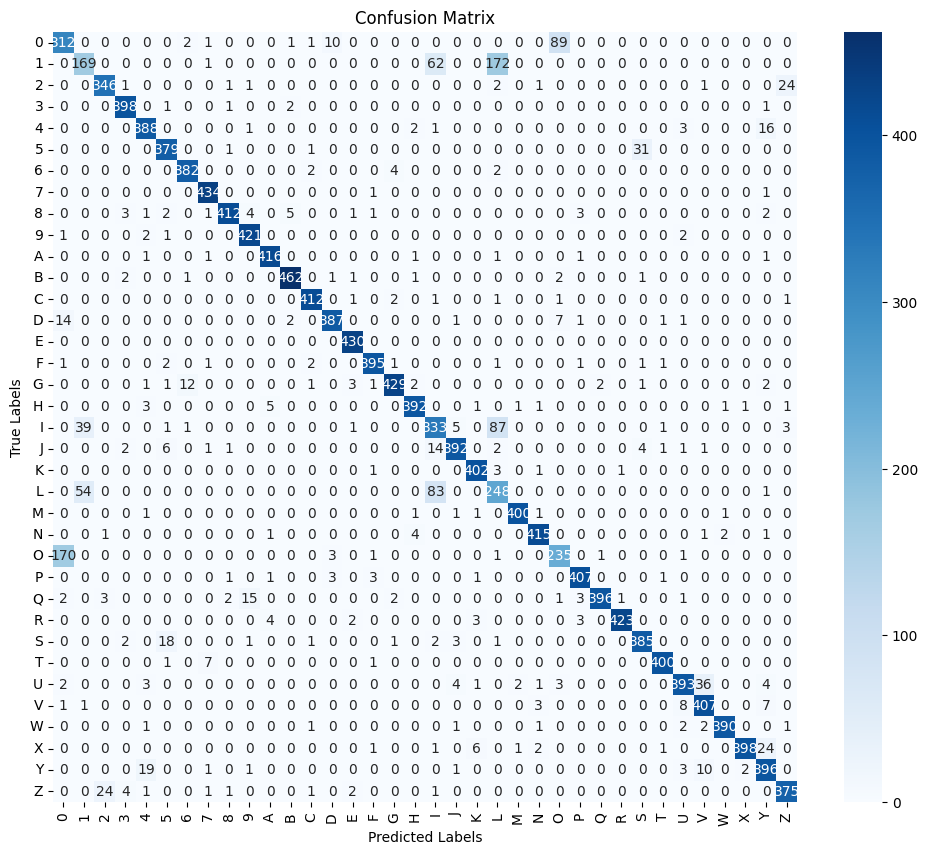

In [118]:
#a. Confusion matrix
# draw_confusion_matrix(true_labels, predicted_labels)
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted_tensor = torch.tensor(predicted_labels)
true_tensor = torch.tensor(true_labels)

confmat = ConfusionMatrix(task="multiclass", num_classes=36)
cm = confmat(predicted_tensor, true_tensor)
cm_numpy = cm.cpu().numpy() if cm.is_cuda else cm.numpy()

plt.figure(figsize=(12, 10))

sns.heatmap(cm_numpy, annot=True, fmt='d', cmap='Blues')

numbers = [f'{i}' for i in range(10)]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

class_names = numbers + alphabets

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.show()

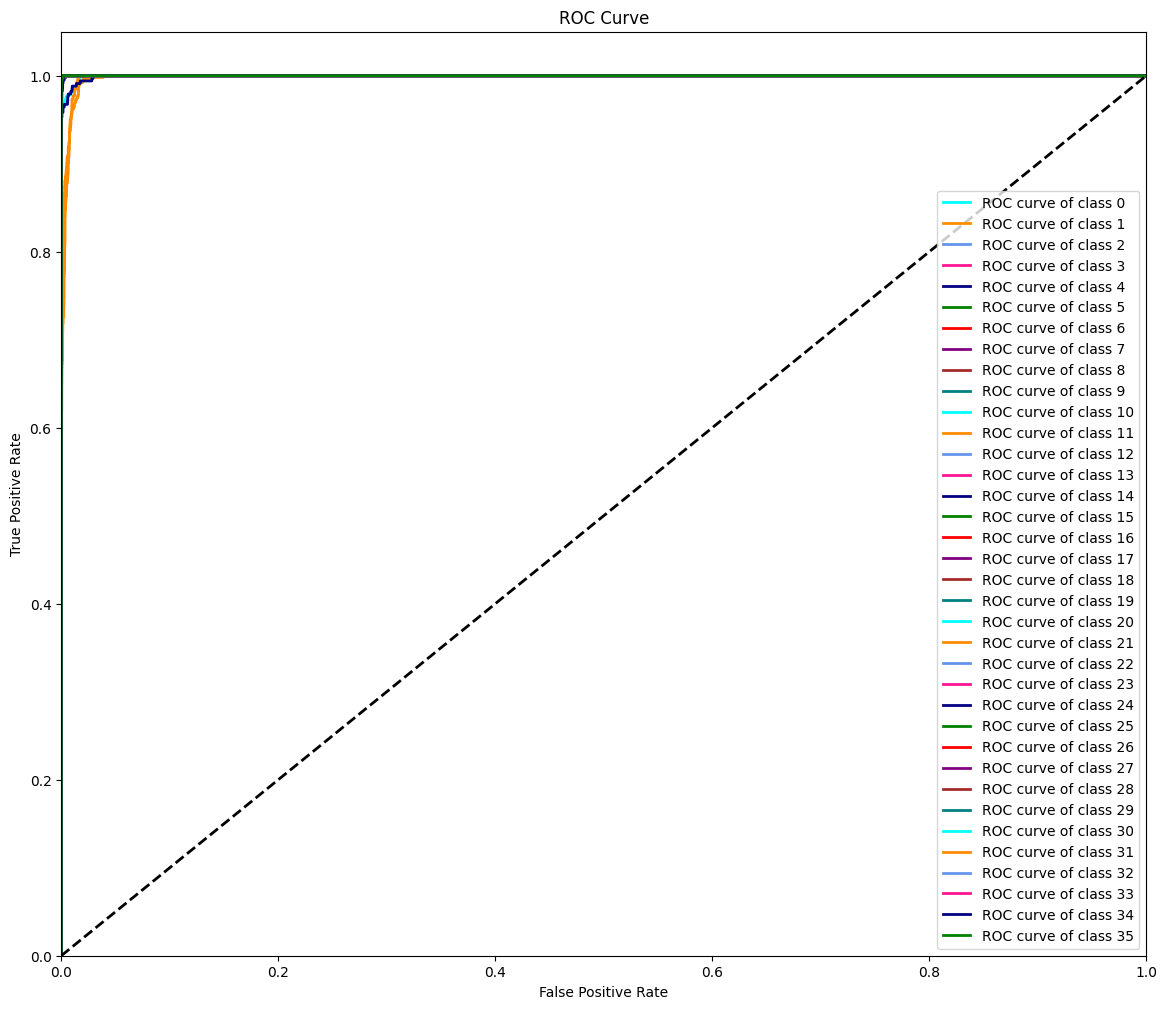

In [119]:
#b. ROC curve
from torchmetrics import ROC

predicted_tensor = torch.tensor(predicted_values)
probabilities = F.softmax(predicted_tensor, dim=1)
label_tensor = torch.tensor(predicted_labels)

roc = ROC(task="multiclass", num_classes = 36)
fpr, tpr, thresholds = roc(probabilities,label_tensor)

import matplotlib.pyplot as plt
from itertools import cycle

n_classes = 36
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy', 'green', 'red', 'purple', 'brown', 'teal'])

plt.figure(figsize=(14, 12))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


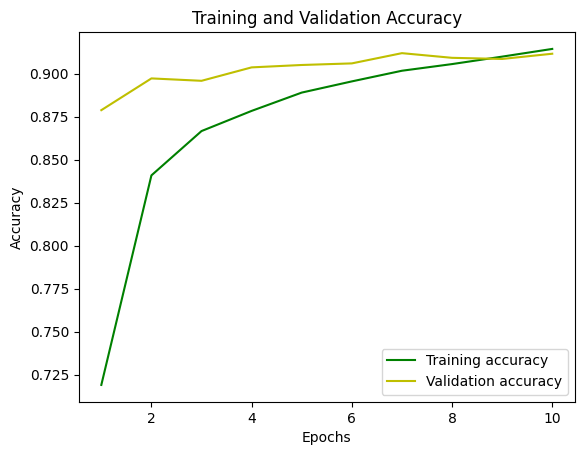

In [120]:
#c. A graph that compares validation and training accuracy
draw_accuracy_graph(ta_list, va_list)


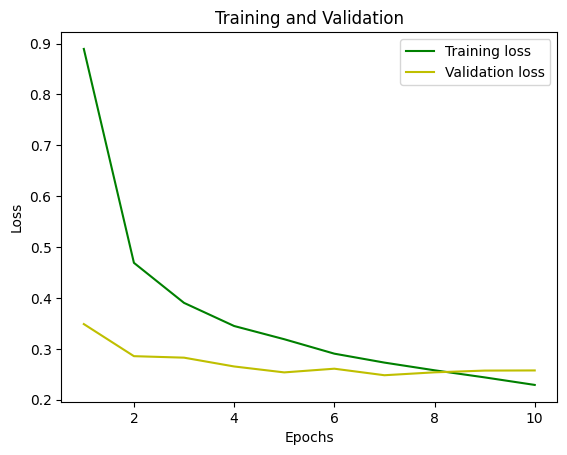

In [121]:
#d. A graph that compares validation and training loss on the same plot
draw_losses_graph(tl_list, vl_list)


In [9]:
class VGGNet11(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 36)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = x.view(-1, 512 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Instantiate the model
VGG_model = VGGNet11()
VGG_model.to('cuda')


VGGNet11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_r

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#2 Train the model using the same data
training_start = time.time()
_, tl_list, vl_list, ta_list, va_list = train_model(VGG_model, train_loader, valid_loader, num_epochs=5)
training_end = time.time()
training_time = training_end - training_start

Epoch 1, Batch 100, Current Loss: 132.12491111755372
Epoch 1, Batch 200, Current Loss: 118.04030155181884
Epoch 1, Batch 300, Current Loss: 112.10929776509603
Epoch 1, Batch 400, Current Loss: 107.73449073791504
Epoch 1, Batch 500, Current Loss: 103.24059913635254
Epoch 1, Batch 600, Current Loss: 98.93824124654134
Epoch 1, Batch 700, Current Loss: 94.5202727835519
Epoch 1, Batch 800, Current Loss: 90.3199255847931
Epoch 1, Batch 900, Current Loss: 86.87483463287353
Epoch 1, Batch 1000, Current Loss: 83.29481508636475
Epoch 1, Batch 1100, Current Loss: 80.20853791670366
Epoch 1, Batch 1200, Current Loss: 76.95855596224467
Epoch 1, Batch 1300, Current Loss: 74.24348790095402
Epoch 1, Batch 1400, Current Loss: 71.52377112865447
Epoch 1, Batch 1500, Current Loss: 68.96699247487386
Epoch 1, Batch 1600, Current Loss: 67.50948051452637
Epoch 1, Batch 1700, Current Loss: 65.58144928876091
Epoch 1, Batch 1800, Current Loss: 63.71671296013726
Epoch 1, Batch 1900, Current Loss: 62.92703234220806

In [18]:
#Save the weights of the trained neural net.
torch.save(model.state_dict(),"VGGModel")

In [11]:
#3 Evaluate the performance of the model using the same data.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG_model.to(device)

# Calling the evaluate_metrics functrion to test and get the required metrics
accuracy, precision, recall, f1, predicted_labels, true_labels, predicted_values = evaluate_metrics(VGG_model, test_loader, device)

print(f'The accuracy of the model is: {accuracy}')
print(f'The precision of the model is:{precision}')
print(f'The recall of the model is:{recall}')
print(f'The f1 of the model is:{f1}')
print(f'The training time of the model is: {training_time} seconds')

The accuracy of the model is: 0.8537698412698412
The precision of the model is:0.8879529914108052
The recall of the model is:0.8537698412698412
The f1 of the model is:0.8561777733095662
The training time of the model is: 1210.166333436966 seconds


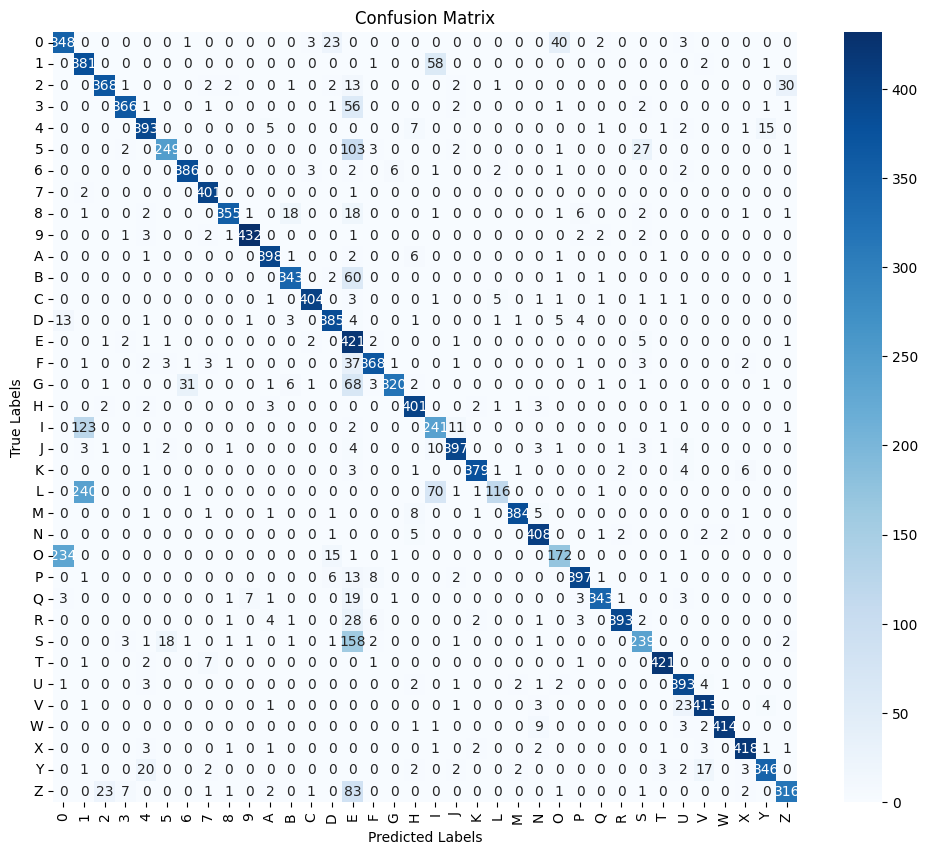

In [12]:
#a. Confusion matrix
# draw_confusion_matrix(true_labels, predicted_labels)

predicted_tensor = torch.tensor(predicted_labels)
true_tensor = torch.tensor(true_labels)

confmat = ConfusionMatrix(task="multiclass", num_classes=36)
cm = confmat(predicted_tensor, true_tensor)
cm_numpy = cm.cpu().numpy() if cm.is_cuda else cm.numpy()

plt.figure(figsize=(12, 10))

sns.heatmap(cm_numpy, annot=True, fmt='d', cmap='Blues')

numbers = [f'{i}' for i in range(10)]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

class_names = numbers + alphabets

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)

# Show the plot
plt.show()

C:\Users\aksho\AppData\Local\Temp\ipykernel_24472\2639763180.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  predicted_tensor = torch.tensor(predicted_values)


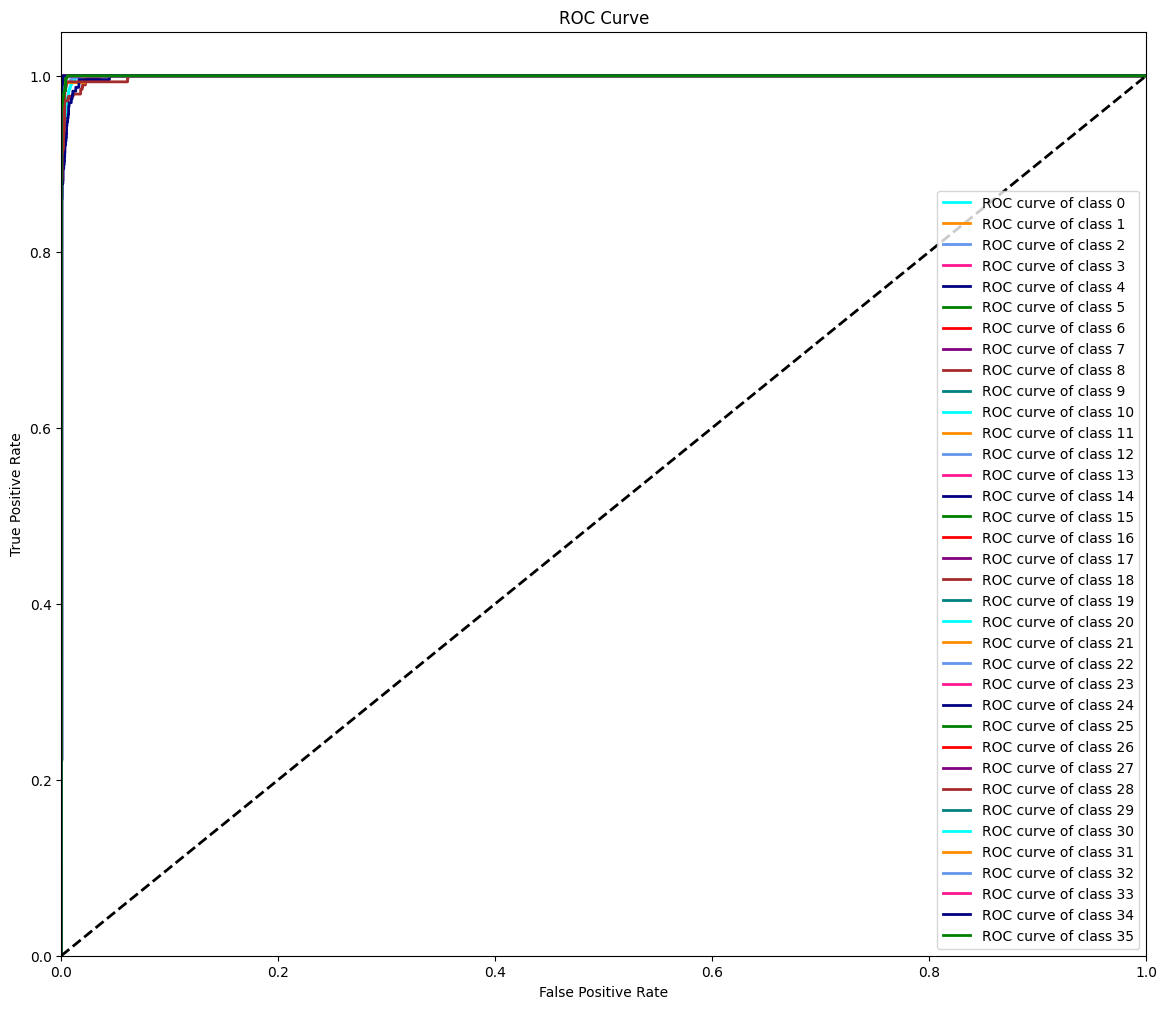

In [13]:
#b. ROC curve
from torchmetrics import ROC

predicted_tensor = torch.tensor(predicted_values)
probabilities = F.softmax(predicted_tensor, dim=1)
label_tensor = torch.tensor(predicted_labels)

roc = ROC(task="multiclass", num_classes = 36)
fpr, tpr, thresholds = roc(probabilities,label_tensor)

import matplotlib.pyplot as plt
from itertools import cycle

n_classes = 36

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy', 'green', 'red', 'purple', 'brown', 'teal'])

plt.figure(figsize=(14, 12))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

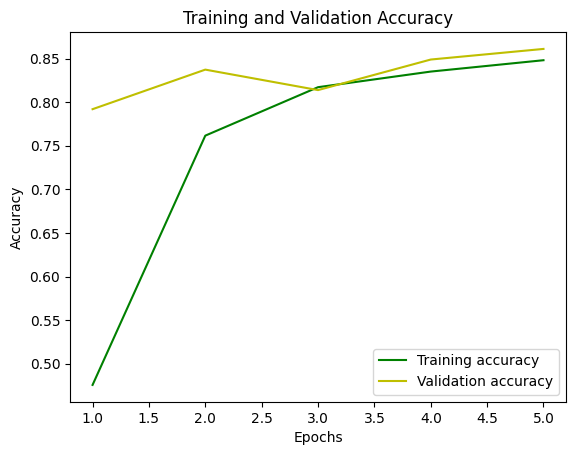

In [17]:
#c. A graph that compares validation and training accuracy
draw_accuracy_graph(ta_list, va_list)

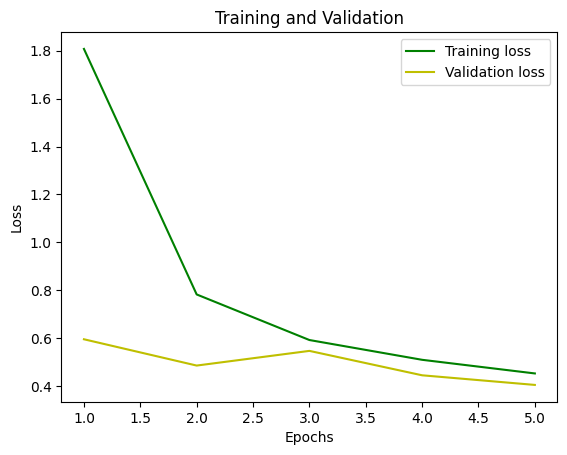

In [16]:
#d. A graph that compares validation and training loss on the same plot
draw_losses_graph(tl_list, vl_list)
